# Transformers for atom

In [1]:
# импорт необходимых библиотек
import re
import pandas as pd
import numpy as np
from transformers import BartTokenizer, BartForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/ruslan/atom/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# загрузка данных
df = pd.read_csv('data/train_df.csv')
df.head()


,Number,Name_uc,Text_uc,Name_ssts,Text_ssts
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet..."
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...


**max_length**  
Этот параметр задает максимальное количество токенов, которые может содержать сгенерированный текст. Если модель достигает этого лимита, генерация останавливается.
Управление: Увеличение этого значения позволяет модели генерировать более длинные ответы, но может привести к менее сжатым и менее релевантным результатам. Если вы ожидаете более короткие ответы, установите меньшее значение.

**num_beams**  
Этот параметр определяет количество "лучей" (beam) в beam search. Beam search — это алгоритм, который сохраняет несколько лучших кандидатов на каждом шаге генерации, а не только один. 
Управление: Увеличение этого значения (например, до 5 или 10) может улучшить качество генерируемого текста, так как модель будет рассматривать больше вариантов. Однако это также увеличивает время генерации. Если вы хотите более разнообразные ответы, можно использовать значение 1, что соответствует жадному поиску.

**early_stopping**  
Этот параметр указывает модели, следует ли остановить генерацию, как только все лучи достигнут конца последовательности (например, специального токена   ).
Управление: Установите значение  True , если хотите, чтобы генерация останавливалась, как только все лучи завершили свою работу. Это может помочь избежать ненужного продолжения генерации.

**temperature**  
Этот параметр контролирует степень случайности в процессе генерации. Чем выше значение температуры, тем более случайными будут генерируемые токены.
Управление: Значение 1.0 соответствует стандартной случайности. Если вы хотите более предсказуемые и безопасные ответы, уменьшите значение (например, до 0.7). Если вы хотите более креативные и разнообразные ответы, увеличьте значение (например, до 1.5).

**top_k**  
Этот параметр ограничивает выбор токенов в процессе генерации. Модель будет рассматривать только  top_k  наиболее вероятных токенов на каждом шаге.
Управление: Увеличение этого значения позволяет модели рассматривать больше вариантов, что может привести к более разнообразным ответам. Однако слишком высокое значение может снизить качество. Значение 50 — это хороший баланс для большинства задач.

**top_p**  
Этот параметр, также известный как nucleus sampling, позволяет модели выбирать токены из общего числа, которые составляют  top_p  вероятности. Например, если  top_p  равно 0.9, модель будет рассматривать только те токены, которые составляют 90% вероятности.
Управление: Установите значение  top_p  между 0.8 и 0.95 для достижения хорошего баланса между разнообразием и качеством. Более низкие значения могут привести к менее креативным ответам.

In [3]:
# Загрузка модели и токенизатора BART
model = BartForConditionalGeneration.from_pretrained("./bart_model")
tokenizer = BartTokenizer.from_pretrained("./bart_model")


In [4]:
def generate_difference(row):
    text1 = row['Text_uc']
    text2 = row['Text_ssts']

    # Форматирование входных данных для модели BART
    input_text = (
        f"Identify the different content, text1 and text2: "
        f"First text: {text1} </s> Second text: {text2}"
    )

    #input_text = f"Find the differences in the second text compared to the first: {text2} </s> {text1}"
    # input_text = (
    #     f"Context the differences in characteristics and specifications between the first text and the second text. "
    #     f"First text: {text1} </s> Second text: {text2}"
    # )
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Проверка длины входных данных на размерность токена 1024
    if input_ids.shape[1] > 1024:
        input_ids = input_ids[:, :1024]

    # Генерация описания расхождений
    if text2 != '-':
        try:
            outputs = model.generate(
                input_ids,
                max_length=60,
                num_beams=7,
                early_stopping=True,
                do_sample=True,
                temperature=0.95,
                top_k=50,
                top_p=0.90
            )
            description = tokenizer.decode(outputs[0], skip_special_tokens=True)
        except IndexError as e:
            print(f"Error during generation: {e}")
            return "Ошибка генерации"
        description = ':'.join(description.split(':')[2:])
    else:
        description = '-'
    return description


In [5]:
%%time
# получения различий в контексте текстов 2 документов
df['Difference'] = df.apply(generate_difference, axis=1)


CPU times: user 4min 16s, sys: 1.77 s, total: 4min 18s
Wall time: 20.2 s


In [6]:
df.head()


,Number,Name_uc,Text_uc,Name_ssts,Text_ssts,Difference
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...,Use Case: Adding Internet Radio to Favorites ...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet...",Preconditions: The driver's smartphone is con...
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...,Goal: Enable the Owner to quickly revoke acce...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...,"Use-Case Title: ""Setting Hotspot name & passw..."
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...,ERA-Glonass system Description: ERA self-diag...


In [7]:
def generate_description(row):


    text1 = row['Text_uc']
    text2 = row['Text_ssts']

    # Форматирование входных данных для модели BART
    input_text = (
        f"Discribe the differences in characteristics and specifications between the first text and the second text. "
        f"First text: {text1} </s> Second text: {text2}"
    )
    #input_text = f"Find the differences in the first text compared to the second: {text1} </s> {text2}"
    #input_text = f"Find the differences in the first text compared to the second that are not in the third: {text1} </s> {text2} </s> {text3}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Проверка длины входных данных на размерность токена 1024
    if input_ids.shape[1] > 1024:
        input_ids = input_ids[:, :1024]

    # Генерация описания расхождений
    try:
        outputs = model.generate(
            input_ids,
            max_length=150,
            num_beams=5,
            early_stopping=True,
            do_sample=True,
            temperature=0.65,
            top_k=50,
            top_p=0.90
        )
        description = tokenizer.decode(outputs[0], skip_special_tokens=True)
    except IndexError as e:
        print(f"Error during generation: {e}")
        return "Ошибка генерации"
    description = ':'.join(description.split(':')[2:])
    return description


In [8]:
%%time
# Применение функции к каждой строке DataFrame
df['Description'] = df.apply(generate_description, axis=1)


CPU times: user 10min 7s, sys: 678 ms, total: 10min 7s
Wall time: 44.2 s


In [9]:
df.head()


,Number,Name_uc,Text_uc,Name_ssts,Text_ssts,Difference,Description
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...,Use Case: Adding Internet Radio to Favorites ...,Adding Internet Radio to Favorites List Goal:...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet...",Preconditions: The driver's smartphone is con...,An incoming call is received on the driver's ...
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...,Goal: Enable the Owner to quickly revoke acce...,Enable the Owner to quickly revoke access fro...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...,"Use-Case Title: ""Setting Hotspot name & passw...","""Setting Hotspot name & password"" Goal: Users..."
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...,ERA-Glonass system Description: ERA self-diag...,ERA self-diagnosis whether the system has a f...


In [10]:
# df.to_csv('data/df_diff_descrip.csv', index=False)


In [11]:
# загрузка модели
model_bert = SentenceTransformer('./roberta_model')


In [12]:
# Загрузка модели DistilBERT

def preprocess_text(text):
    if text == '-':  # Проверка на NaN
        return "-"
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    return text

# Функция для вычисления косинусного сходства
def compute_cosine_similarity(row):
    text1 = preprocess_text(row['Text_uc'])
    text2 = preprocess_text(row['Difference'])

    # Проверка на наличие NaN значений
    if text1 == '-' or text2 == '-':
        return 0

    # Получение векторных представлений для текстов
    embeddings1 = model_bert.encode(text1)
    embeddings2 = model_bert.encode(text2)

    # Вычисление косинусного сходства
    cosine_similarity = util.pytorch_cos_sim(embeddings1, embeddings2)

    return cosine_similarity.item()


In [13]:
df.head()


,Number,Name_uc,Text_uc,Name_ssts,Text_ssts,Difference,Description
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...,Use Case: Adding Internet Radio to Favorites ...,Adding Internet Radio to Favorites List Goal:...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet...",Preconditions: The driver's smartphone is con...,An incoming call is received on the driver's ...
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...,Goal: Enable the Owner to quickly revoke acce...,Enable the Owner to quickly revoke access fro...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...,"Use-Case Title: ""Setting Hotspot name & passw...","""Setting Hotspot name & password"" Goal: Users..."
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...,ERA-Glonass system Description: ERA self-diag...,ERA self-diagnosis whether the system has a f...


In [14]:
# Применение функции к каждой строке DataFrame
df['cosine_similarity'] = df.apply(compute_cosine_similarity, axis=1)


In [15]:
df[['Number',  'Name_uc', 'Name_ssts', 'cosine_similarity']].style.background_gradient(subset="cosine_similarity", cmap="summer_r")

,Number,Name_uc,Name_ssts,cosine_similarity
0,31523,Adding Internet Radio to Favorites List,Favorite Song operation,0.856127
1,8800,Receiving Call Notifications,Receiving Call Notifications,0.851333
2,11467,Revoke access to the vehicle from a driver or passenger,"Users can remotely control the DK deletion through the ATOM app, and the DK list is updated after deletion.",0.893668
3,28561,Setting Hotspot name & password,hotspot settings,0.882102
4,30371,ERA Self-diagnosis,ERA Self-diagnosis,0.682320
5,8692,Emergency Service Communication (ERA-Glonass),Manual dialing E-CALL,0.845346
6,26160,Filtering the internet radio stations,-,0.000000
7,25957,Mute/unmute the FM Radio playback,Mute or pause function,0.929815
8,26771,Turn on and off hotspot via VA,Turn on and off hotspot,0.786805
9,8604,Source selection for Media output,Switch music sources,0.837150


In [16]:
# оценка соответствия
df['len'] = df['Difference'].map(lambda x: len(x))
df['len_worlds'] = df['Difference'].map(lambda x: len(x.split()))
df['total_score'] = df.apply(lambda x: (x['len_worlds'] / x['len'] * 0.1) + (x['cosine_similarity'] * 0.9) if x['Text_ssts'] != '-' else 0, axis=1)

In [17]:
df[['Number',  'Name_uc', 'Name_ssts', 'total_score']].style.background_gradient(subset="total_score", cmap="summer_r")

,Number,Name_uc,Name_ssts,total_score
0,31523,Adding Internet Radio to Favorites List,Favorite Song operation,0.786221
1,8800,Receiving Call Notifications,Receiving Call Notifications,0.781585
2,11467,Revoke access to the vehicle from a driver or passenger,"Users can remotely control the DK deletion through the ATOM app, and the DK list is updated after deletion.",0.820801
3,28561,Setting Hotspot name & password,hotspot settings,0.810077
4,30371,ERA Self-diagnosis,ERA Self-diagnosis,0.627838
5,8692,Emergency Service Communication (ERA-Glonass),Manual dialing E-CALL,0.775168
6,26160,Filtering the internet radio stations,-,0.000000
7,25957,Mute/unmute the FM Radio playback,Mute or pause function,0.851833
8,26771,Turn on and off hotspot via VA,Turn on and off hotspot,0.726912
9,8604,Source selection for Media output,Switch music sources,0.770018


In [18]:
def complience_level(value) -> str:
    """функция интерпритации соответствия

    Args:
        value (_type_): показатель соответствия

    Returns:
        str: метка класса
    """
    if value > 0.83:
        return 'FC'
    elif value > 0.75 and value <= 0.83:
        return 'LC'
    elif 0.01 < value <= 0.75:
        return 'NC'
    else:
        return 'NA'

In [19]:
# применение функции
df['Complience Level'] = df['total_score'].map(complience_level)
df

,Number,Name_uc,Text_uc,Name_ssts,Text_ssts,Difference,Description,cosine_similarity,len,len_worlds,total_score,Complience Level
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...,Use Case: Adding Internet Radio to Favorites ...,Adding Internet Radio to Favorites List Goal:...,0.856127,191,30,0.786221,LC
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet...",Preconditions: The driver's smartphone is con...,An incoming call is received on the driver's ...,0.851333,182,28,0.781585,LC
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...,Goal: Enable the Owner to quickly revoke acce...,Enable the Owner to quickly revoke access fro...,0.893668,200,33,0.820801,LC
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...,"Use-Case Title: ""Setting Hotspot name & passw...","""Setting Hotspot name & password"" Goal: Users...",0.882102,173,28,0.810077,LC
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...,ERA-Glonass system Description: ERA self-diag...,ERA self-diagnosis whether the system has a f...,0.682320,160,22,0.627838,NC
5,8692,Emergency Service Communication (ERA-Glonass),Preconditions: The vehicle is in the Drive Sta...,Manual dialing E-CALL,The user presses the SOS button to actively tr...,Preconditions: The vehicle is in the Drive St...,The vehicle is in the Drive State (PRND) the ...,0.845346,202,29,0.775168,LC
6,26160,Filtering the internet radio stations,Goal: 'Reorder the Internet Radio stations by ...,-,-,-,'Reorder the Internet Radio stations by the a...,0.000000,1,1,0.000000,NA
7,25957,Mute/unmute the FM Radio playback,Preconditions: User is playing FM Radio Main S...,Mute or pause function,"When playing online radio stations, pause oper...",Preconditions: User is playing FM Radio Main ...,User is playing FM Radio Main Scenario: ​​​Us...,0.929815,140,21,0.851833,FC
8,26771,Turn on and off hotspot via VA,"Use-Case Title: ""Turn on and off hotspot via V...",Turn on and off hotspot,Users can choose to turn on or off the car hot...,"Use-Case Title: ""Turn on and off hotspot via ...","""Turn on and off hotspot via VA"" Goal: Users ...",0.786805,165,31,0.726912,NC
9,8604,Source selection for Media output,Goal: Enable user selection of multimedia audi...,Switch music sources,Users can switch music sources through the SWP...,Goal: Enable user selection of multimedia aud...,Enable user selection of multimedia audio sou...,0.837150,199,33,0.770018,LC


In [22]:
# формирование файла отчёта
sub = df[['Number', 'Name_uc', 'Difference', 'Description', 'Complience Level']]
sub = sub.rename(columns={"Name_uc" : 'Name'})
sub.head()

,Number,Name,Difference,Description,Complience Level
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites ...,Adding Internet Radio to Favorites List Goal:...,LC
1,8800,Receiving Call Notifications,Preconditions: The driver's smartphone is con...,An incoming call is received on the driver's ...,LC
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acce...,Enable the Owner to quickly revoke access fro...,LC
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passw...","""Setting Hotspot name & password"" Goal: Users...",LC
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diag...,ERA self-diagnosis whether the system has a f...,NC


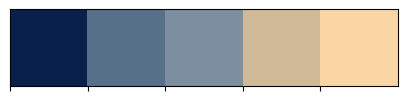

In [23]:
# задание палитры цветов
colors = ["#09214a", "#567189", "#7B8FA1", "#CFB997", "#FAD6A5"]
sns.palplot(sns.color_palette(colors))

In [24]:
# подсчет количества оценок
cl_count = sub["Complience Level"].value_counts()

In [25]:
# наименование классов
cl_count.index.to_list()

['LC', 'NC', 'NA', 'FC']

In [26]:
# упорядочивание классов по значимости
col_names = [col_name for col_name in ["FC", "LC", "PC", "NC", "NA"] if col_name in cl_count.index.to_list()]

In [27]:
# подсчет количества оценок
cl_count = sub["Complience Level"].value_counts()
cl_count = cl_count[col_names]
cl_count

Complience Level
FC    1
LC    7
NC    3
NA    1
Name: count, dtype: int64

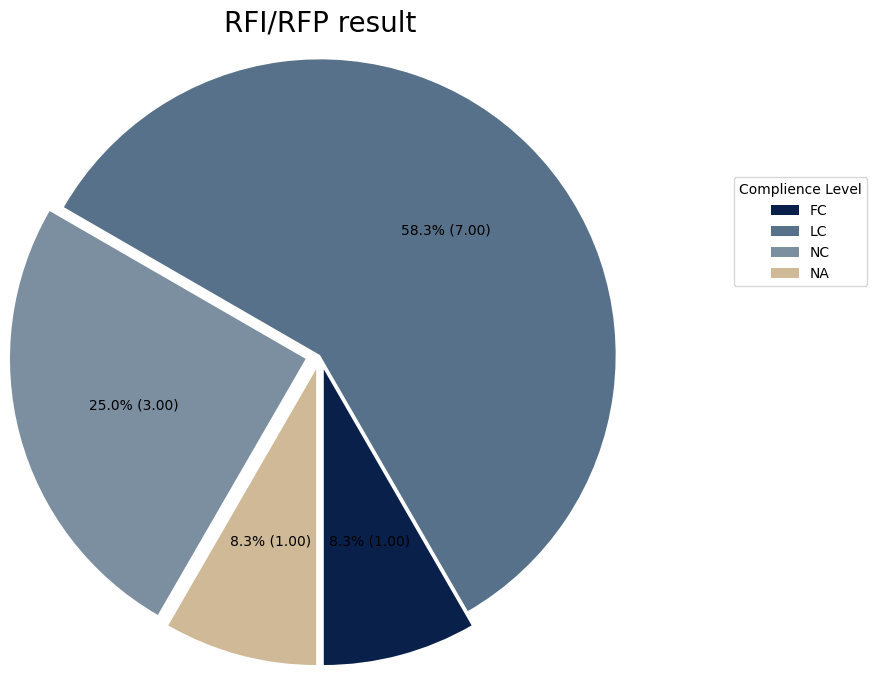

In [28]:
# визуализация соотношения оценок
def func(pct, allvals):
    absolute = float(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:.2f})".format(pct, absolute)

plt.pie(cl_count , colors=colors[:len(col_names)], \
        autopct=lambda pct: func(pct, cl_count), radius=2, startangle = 270, explode = [0.1, 0, 0.1, 0.1, 0.05][:len(col_names)])
plt.title("RFI/RFP result", size = 20, pad=100)
plt.legend(labels=cl_count.index, title ="Complience Level", loc="upper right", bbox_to_anchor =(1.5, 0, 0.5, 1))
plt.show()

In [29]:
sub.to_csv('data/submission.csv', index = False)
